# Gradiente e Classificação multinomial

Nícolas Hecker Silva RA 186132


## Descrição 

Esta tarefa explora conceitos de c ́alculo vetorial, otimiza ̧c ̃ao e m ́etodos de gradiente descendente no contexto de aprendizado de m ́aquina, com foco em classifica ̧c ̃ao multinomial.

## Etapa 1: Funções Convexas e Otimização

Dado uma função $f(x) = x^TAx + b^Tx + c$ faça três versões mudando a matriz A para que a função seja:


- Fortemente Convexa.
- Convexa.
- Não Convexa.

Evidencia cada uma das propriedades.


Dado o enunciado acima, como não foram especificados os tipos das variáveis e constantes será assumido que:
x: É um vetor coluna de dimensão n (nx1)
A: É uma matriz quadrada de dimensão nxn
b: É um vetor coluna de dimensão n (nx1)
c: É um escalar

Dessa forma a dimensão das parcelas será:

$x^TAx = (nx1)^T * (nxn) * (nx1) = (1xn) * (nxn) * (nx1) = (1)$

$b^Tx = (nx1)^T * (nx1) = (1xn) * (nx1) = (1)$

$c = (1)$

Dessa forma f(x) retornará um valor real.

Uma função $ f: \mathbb{R}^n \to \mathbb{R} $ é **fortemente convexa** com parâmetro $ m > 0 $ se, para todo $ x, y \in \mathbb{R}^n $, satisfizer:

$
f(x) \geq f(y) + \nabla f(y)^T (x - y) + \frac{m}{2} \| x - y \|^2.
$

Se $ f(x) = x^T A x + b^T x + c $, para que $ f $ seja fortemente convexa, a matriz $ A $ deve ser **positiva definida** com todos os autovalores maiores ou iguais a $ m $, ou seja, $ \lambda_{\min}(A) \geq m > 0 $.

Por fim, basta que o menor autovalor de $A$ seja maior que 0, sendo (novamente) **positiva definida**. E para isso, basta ela ser simétrica. Uma matriz exemplo seria

$$
A = \begin{pmatrix}
  2 & 0 \\
  0 & 3 
\end{pmatrix}
$$

cujos autovalores são exatamente 2 e 3.

Já para a função ser **convexa** basta que seus autovalores sejam não negativos, ou seja, eles podem ser nulos. Dessa forma, a matriz exemplo

$$
A = \begin{pmatrix}
  2 & 0 \\
  0 & 0
\end{pmatrix}
$$

terá os autovalores 0 e 2, fazendo com que f(x) seja **convexa**.

Dessa forma, para que a função f seja **não convexa**, é necessário que algum autovalor seja negativo, pois nesse caso a função f(x) não terá curvatura positiva em todas as direções, podendo curvar-se para baixo em algumas direções, o que viola a convexidade.

Um exemplo é a matriz

$$
A = \begin{pmatrix}
  2 & 0 \\
  0 & -1
\end{pmatrix}
$$

em que os autovalores são 2 e -1, sendo -1 um valor negativo fazendo com que A não seja semidefinida positiva.



In [ ]:
import os
import numpy as np
import struct
from array import array
from os.path  import join

Uma primeira parte muito importante é baixar o dataset mnist. Ele será baixado usando o comando shell curl e será colocado na pasta dataset-t3

In [ ]:
# cria pasta dataset-t3
os.makedirs('dataset-t3', exist_ok=True)

if not os.path.exists('dataset-t3/d.zip'):
    !curl -L -o dataset-t3/d.zip\
    https://www.kaggle.com/api/v1/datasets/download/hojjatk/mnist-dataset
    !unzip dataset-t3/d.zip -d dataset-t3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22.0M  100 22.0M    0     0  7996k      0  0:00:02  0:00:02 --:--:-- 14.2M
Archive:  dataset-t3/d.zip
  inflating: dataset-t3/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: dataset-t3/t10k-images.idx3-ubyte  
  inflating: dataset-t3/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: dataset-t3/t10k-labels.idx1-ubyte  
  inflating: dataset-t3/train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: dataset-t3/train-images.idx3-ubyte  
  inflating: dataset-t3/train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: dataset-t3/train-labels.idx1-ubyte  


Para verificar as imagens (uma vez q a extensão delas não é visível), vamos usar o código fornecido pelos autores do MNIST no kaggle (duas células abaixo)

In [ ]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)   

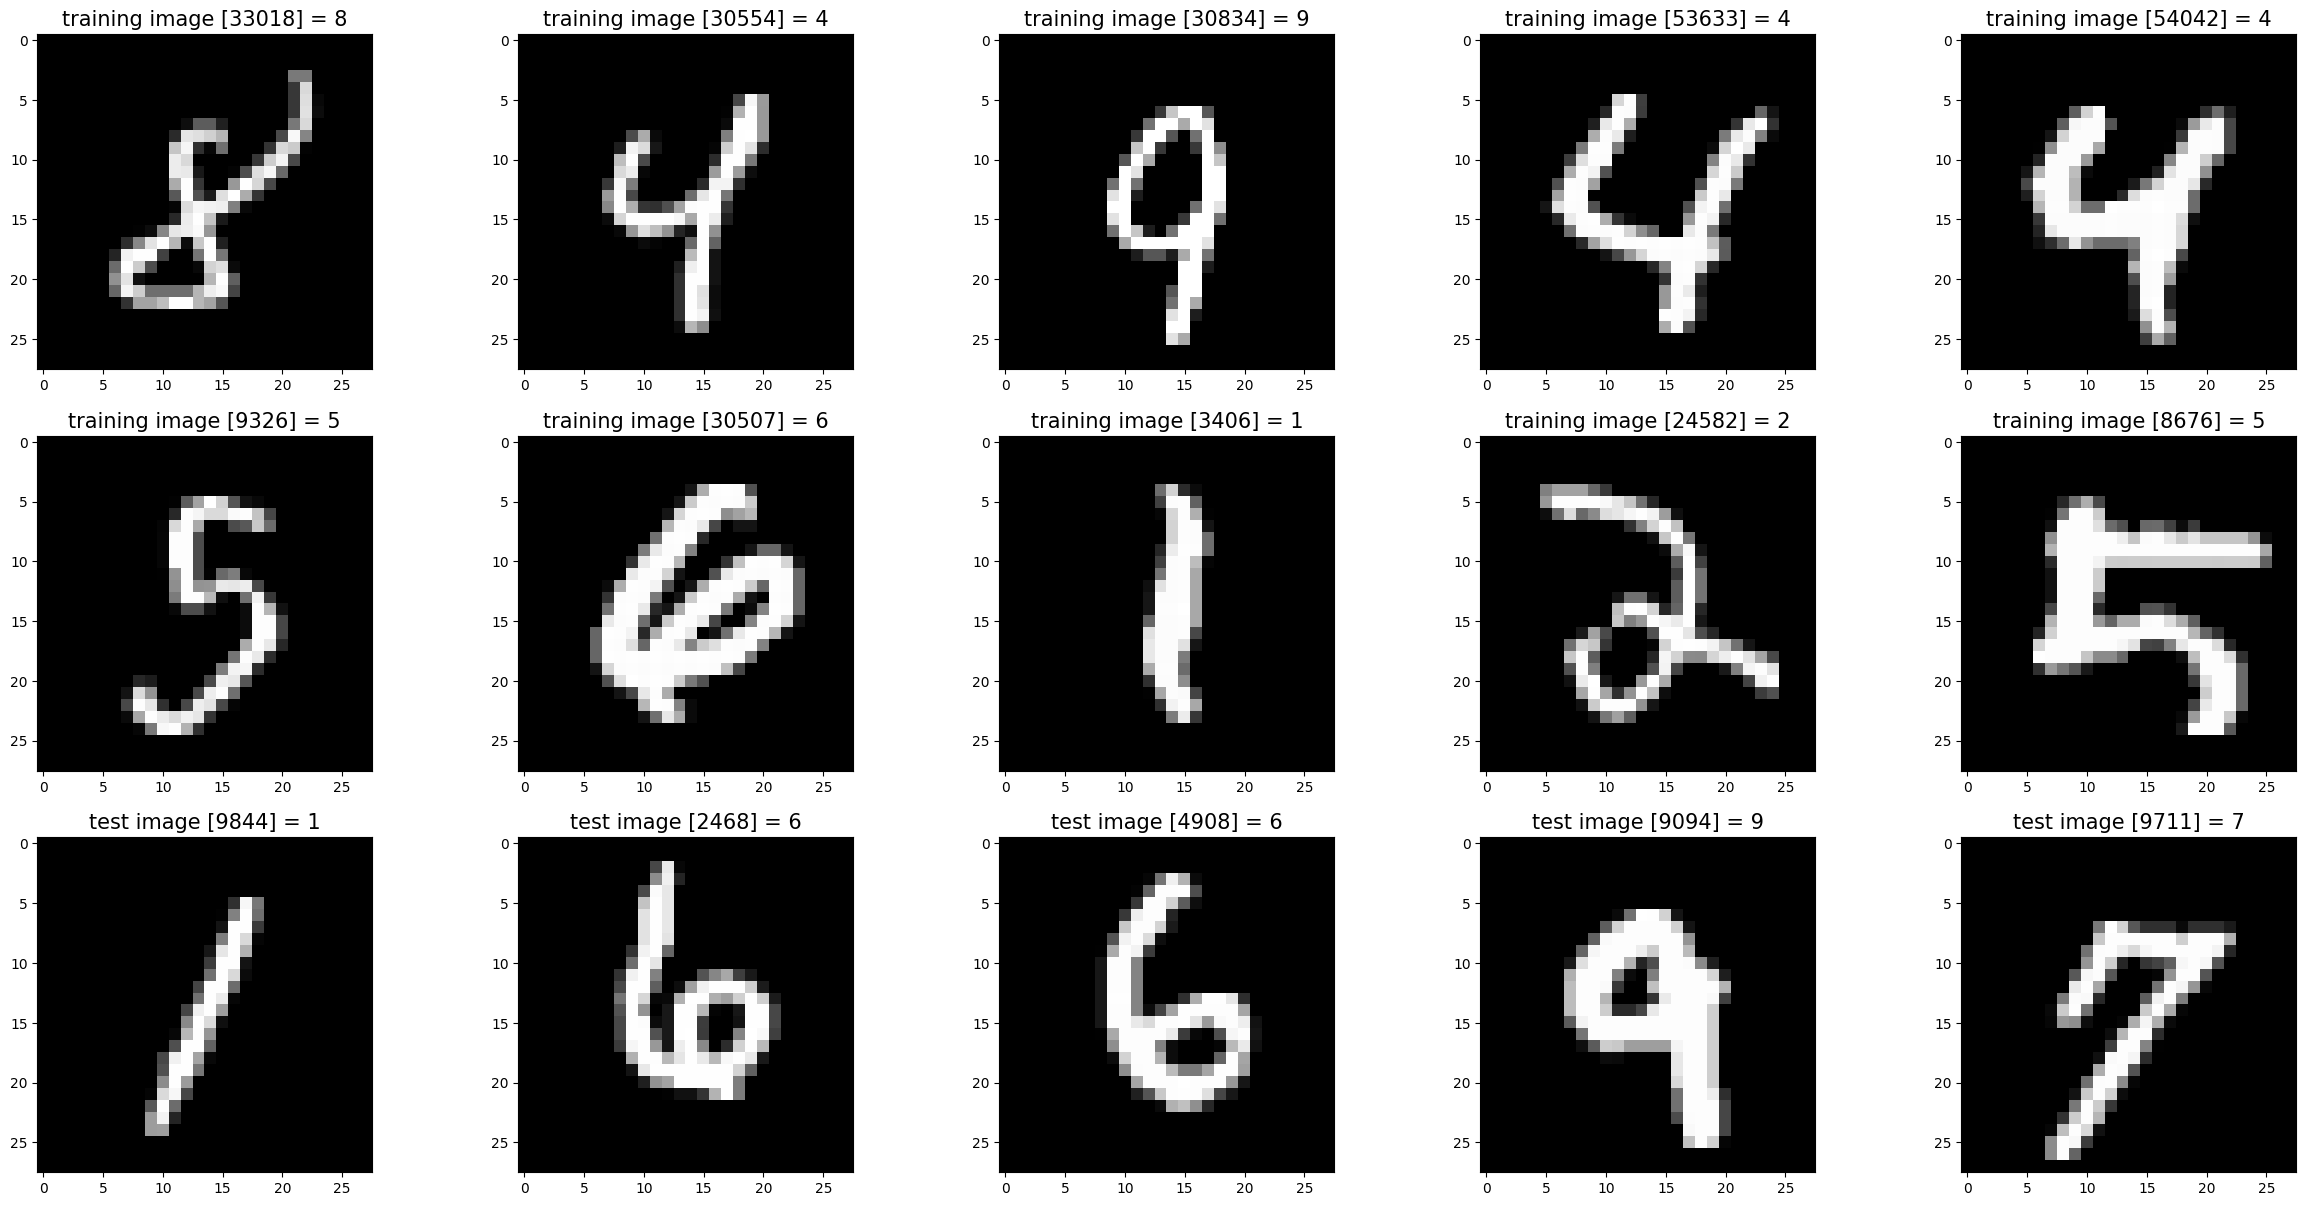

In [ ]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'dataset-t3'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [54]:
x_train = np.array(x_train)
x_test = np.array(x_test)


print('x_train.shape =', x_train.shape)
print('y_train.shape =', np.array(y_train).shape)

x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)


In [ ]:
# Função softmax para calcular probabilidades
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Evitar overflow numérico
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Função de perda para cross-entropy
def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    logp = -np.log(y_pred[range(n_samples), y_true])
    loss = np.sum(logp) / n_samples
    return loss

# Gradiente descendente para treinar o modelo
def train(X, y, n_classes, learning_rate=0.01, n_iter=1000):
    n_samples, n_features = X.shape
    W = np.random.rand(n_features, n_classes)
    b = np.zeros((1, n_classes))

    for i in range(n_iter):
        # Cálculo de logits e probabilidades
        logits = np.dot(X, W) + b
        y_pred = softmax(logits)

        # Calcular e atualizar os gradientes
        y_one_hot = np.eye(n_classes)[y]
        grad_W = (1 / n_samples) * np.dot(X.T, (y_pred - y_one_hot))
        grad_b = (1 / n_samples) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)

        W -= learning_rate * grad_W
        b -= learning_rate * grad_b

        if i % 100 == 0:
            loss = cross_entropy_loss(y, y_pred)
            print(f"Iteração {i}, Perda: {loss:.4f}")

    return W, b

# Prever as classes
def predict(X, W, b):
    logits = np.dot(X, W) + b
    y_pred = softmax(logits)
    return np.argmax(y_pred, axis=1)


X, y = x_train, y_train
n_classes = len(np.unique(y))

# Treinamento
W, b = train(X, y, n_classes)

# Previsão e avaliação
y_pred = predict(X, W, b)
accuracy = np.mean(y_pred == y)
print(f"Acurácia do modelo manual: {accuracy * 100:.2f}%")


ValueError: too many values to unpack (expected 2)